In [2]:
"""
Tutorials: 
- http://mccormickml.com/2019/07/22/BERT-fine-tuning/ (simplified version of run_glue.py from huggingface)
"""
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
assert device_name == "/device:GPU:0", "device name is: '{}'. GPU device not found".format(device_name)


In [0]:
! pip3 install torch torchvision


     |████████████████████████████████| 734.6MB 23kB/s 


In [8]:
import torch

device = torch.device("cuda")
print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [13]:
!pip install transformers

     |████████████████████████████████| 450kB 3.4MB/s 
     |████████████████████████████████| 1.0MB 24.9MB/s 
     |████████████████████████████████| 860kB 57.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=d6ec781e90e7beab953f7e4b84c13d4ce11c65cfea7c5ec6b4a32cfcbd11f73f
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [9]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=fefcf61ddea695421f4b8a54ba6a00e1bfe57bf635ac57d30e86c69c18521f4a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [10]:
import wget
import os
url = "https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')
    print("Successfully downloaded cola_public_1.1.zip")
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Successfully downloaded cola_public_1.1.zip
Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [11]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', 
                 header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
4590,ks08,0,*,"He never achieved anything, didn't he?"
1285,r-67,0,*,I went to the movies not to pick the shirts up.
7715,ad03,1,NaN,He's bound to could do it
988,bc01,1,NaN,The ship's sinking was very devious.
3018,l-93,1,NaN,I hunted game in the woods.
4747,ks08,1,NaN,With what did the baby eat the food?
7342,sks13,1,NaN,They surrounded the fort.
6210,c_13,1,NaN,John was bitten by an advertising executive.
8366,ad03,1,NaN,Aphrodite may quickly free the animals.
6381,d_98,1,NaN,Almost any pilot could be flying this plane.


In [14]:
from transformers import BertTokenizer
print("Loading the BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

Loading the BERT tokenizer...


In [15]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

print('Original:  ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:   Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [16]:
# Sentences to IDs: Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sent,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print("Original: ", sentences[0])
print("Token IDs:", input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [17]:
# We'll borrow the `pad_sequences` utility function
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 64
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

print('Successfully finished with padding')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0
Successfully finished with padding


Using TensorFlow backend.


In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [19]:
# Use train_test_split to split our data into train and validation sets
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=2018, test_size=0.1
    )
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# Convert all inputs and labels into torch tensors, the required data types
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
print("Succcessfully finished with train test splitting")

Succcessfully finished with train test splitting


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # 2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''Takes a time in seconds and returns a string hh:mm:ss'''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [25]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []  # Store the average loss after each epoch so we can plot them.
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!\n")


======== Epoch 1 / 5 ========
Training...
  Batch     0  of    241.    Elapsed: 0:00:00.
  Batch    40  of    241.    Elapsed: 0:00:09.
  Batch    80  of    241.    Elapsed: 0:00:19.
  Batch   120  of    241.    Elapsed: 0:00:28.
  Batch   160  of    241.    Elapsed: 0:00:37.
  Batch   200  of    241.    Elapsed: 0:00:47.
  Batch   240  of    241.    Elapsed: 0:00:56.
  Average training loss: 0.49
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:02

======== Epoch 2 / 5 ========
Training...
  Batch     0  of    241.    Elapsed: 0:00:00.
  Batch    40  of    241.    Elapsed: 0:00:09.
  Batch    80  of    241.    Elapsed: 0:00:19.
  Batch   120  of    241.    Elapsed: 0:00:28.
  Batch   160  of    241.    Elapsed: 0:00:37.
  Batch   200  of    241.    Elapsed: 0:00:46.
  Batch   240  of    241.    Elapsed: 0:00:56.
  Average training loss: 0.31
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:02


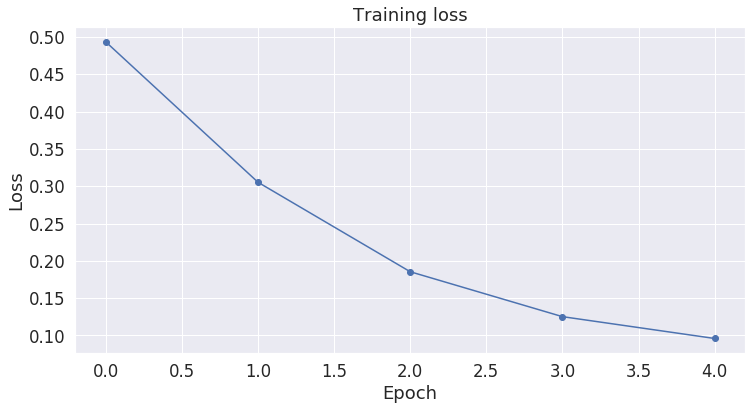

In [26]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()